# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.


Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from rted import rted

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.3.post53.dev0+g380ad105
2.7.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee14_base.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Parsing input file "/home/jwang175/andes/jwang/case/ieee14_base.xlsx"...
Input file parsed in 0.1872 seconds.
System internal structure set up in 0.0409 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 2.237 p.u.


Text(0.5, 0, 'Time [s]')

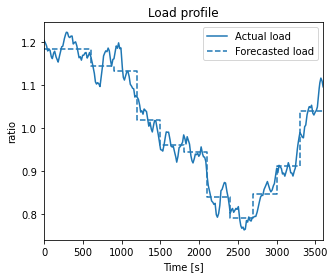

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 100
d_syn['s10'] = (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ssa)

# add gen cost
gen_cost = np.array([
    [2, 0, 0, 3, 0.0, 40, 0],
    [2, 0, 0, 3, 0.0, 25, 0],
    [2, 0, 0, 3, 0.0, 30, 0],
    [2, 0, 0, 3, 0.0, 31, 0],
    [2, 0, 0, 3, 0.0, 32, 0],
    [2, 0, 0, 3, 0.0, 33, 0]
])

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1058 seconds.
0: |F(x)| = 0.5605182162
1: |F(x)| = 0.006127943757
2: |F(x)| = 5.694809117e-06
3: |F(x)| = 5.725184216e-12
Converged in 4 iterations in 0.0077 seconds.
Power flow results are consistent. Conversion is successful.


True

**NOTE**: Alter the controllability of generator by modifying ``ssp.gen.controllable``

In [8]:
# set EV generator as uncontrollable
ssp.gen.controllable.iloc[4] = False

In [9]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_2,1,40.000,1.03,100.0,-40.0,15.0,1.0,False,True,None,True,10.0,50.0,NaN
1,PV_3,2,40.000,1.01,100.0,-10.0,15.0,1.0,False,True,None,True,10.0,50.0,NaN
2,PV_4,5,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,None,True,10.0,100.0,NaN
3,PV_5,7,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,None,True,10.0,50.0,NaN
4,PV_6,3,-1.000,1.01,100.0,0.0,0.0,1.0,False,True,None,False,-10.0,10.0,NaN
5,Slack_1,0,81.442,1.03,100.0,-50.0,100.0,1.0,True,True,None,True,50.0,300.0,NaN


Build DCOPF instance ``ssd``

In [10]:
ssd = rted(ssp)

GSF is consistent.


Alter the EV generator type in ``ssd``

In [11]:
ssd.def_type(['gen6'])

True

Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [12]:
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=[0.1, 0.5, 1, 0.147, -0.01, 0.5])
ssd.build_sdc()
ssd.dcopf.optimize()

pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ppres['p_mw(GB)'] = ssp.sn_mva * ssd.get_res('dcopf')['p_sch'].values
print(f"pp cost={ssp.res_cost}")
ppres

pru_max length does not match Type II generator numbers!
prd_max length does not match Type II generator numbers!


Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 73 rows, 18 columns and 226 nonzeros
Model fingerprint: 0xd1ad8168
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 71 rows and 13 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2775000e+01   9.470000e-01   0.000000e+00      0s
       1    6.7557000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.755700000e+01


dcopf cost (p.u.): Total=67.557, GEN=67.557, SFR=0.0


pp cost=6723.700000074766


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,10.0,NaN,-1.233634,1.0,10.0
1,50.0,NaN,-1.952871,1.0,50.0
2,100.0,NaN,1.644258,1.0,100.0
3,14.7,NaN,-1.284473,1.0,14.7
4,-1.0,NaN,-2.574234,1.0,-1.0
5,50.0,NaN,0.000000,1.0,50.0


Test RTED model of ``ssd``

In [13]:
# def. parameters
ssd.def_ps(c_ru=[], c_rd=[], rampu=[], rampd=[])
# # def. variables
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=[],
            gen=['gen6'], pru_max=[0], prd_max=[0])

ssd.build_rted()

ssd.rted.optimize()

ssd.get_res('rted')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 61 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x73783220
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 59 rows and 13 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2775000e+01   9.470000e-01   0.000000e+00      0s
       1    6.7557000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.755700000e+01


rted cost (p.u.): Total=67.557, GEN=67.557, SFR=0.0


,gen_pp,p_sch,pru,prd,bu,bd
name,,,,,,
gen1,PV_2,0.100,0.0,0.0,0.0,0.0
gen2,PV_3,0.500,0.0,0.0,0.0,0.0
gen3,PV_4,1.000,0.0,0.0,0.0,0.0
gen4,PV_5,0.147,0.0,0.0,0.0,0.0
gen5,PV_6,-0.010,0.0,0.0,0.0,0.0
gen6,Slack_1,0.500,0.0,0.0,0.0,0.0


## Prepare

### Make link table

In [14]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,Slack_1,1.0,Slack_1,1,False,GENROU_1,ESST3A_2,TGOV1_1,BUS1,1.0,1.0,5,True
1,PV_2,1.0,PV_2,2,False,GENROU_2,EXST1_1,TGOV1_2,BUS2,1.0,1.0,0,True
2,PV_3,1.0,PV_3,3,False,GENROU_3,ESST3A_3,TGOV1_3,BUS3,1.0,1.0,1,True
3,PV_4,1.0,PV_4,6,False,GENROU_4,ESST3A_4,TGOV1_4,BUS6,1.0,1.0,2,True
4,PV_5,1.0,PV_5,8,False,GENROU_5,ESST3A_5,TGOV1_5,BUS8,1.0,1.0,3,True
5,PV_6,1.0,PV_6,4,EV_1,False,False,False,BUS4,0.5,0.5,4,False
6,PV_6,1.0,PV_6,4,EV_2,False,False,False,BUS4,0.5,0.5,4,False


### Define functions used in loop

In [15]:
# --- def functions ---
def get_pe(ssa, syg_idx, dg_idx, ssa_key2):
    """Get the active power (SynGen/DG) after TDS, a DataFrame"""
    # SynGen
    pe_syg = ssa.SynGen.get(src='Pe', idx=syg_idx, attr='v')
    # DG
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # out
    pe = pd.DataFrame()
    pe['idx'] = syg_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'syg_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum):
    """Calc SFR requirements ``dpd_u``and ``dpd_d``, and load forecasted value"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(ssa_p0_sum * (load_ci[0] - load_exp))
    load_u = abs(ssa_p0_sum * (load_ci[1] - load_exp))
    return load_u, load_d, load_exp

## Define param

In [16]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.1
Ki = 0.1

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [17]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 0.98

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(t_total): # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva

        # --- RTED, update gen limits after SFR ---
        ssd = rted(ssp)
        if end_time > 0:
            # TODO: INPUT ramp limits data
            rampu = [100] * ssd.gendata.shape[0]
            rampd = [100] * ssd.gendata.shape[0]
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_syg_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssd.gendata[['gen_pp']].rename(columns={'gen_pp': 'stg_idx'}),
                                 on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds['pe'].tolist()
        else:
            rampu = [100] * ssd.gendata.shape[0]
            rampd = [100] * ssd.gendata.shape[0]
            # DCOPF results as the initial previous setpoints
            p_pre = list(ssp.res_gen.p_mw / ssp.sn_mva)

        # TODO: INPUT cost and ramp, ramp should be p.u.
        ssd.def_ps(c_ru=[], c_rd=[], rampu=[], rampd=[])

        # def sfr requirements and ev sfr limtis (p.u.)
        # TODO: Integrate EV; EV limits FROM EV; now set 0 to disable EV SFR
        ssd.def_var(ptotal=ssa_p0_sum * load_exp,
                    dpd_u=du, dpd_d=dd, p_pre=p_pre,
                    gen=['gen5'], pru_max=[0], prd_max=[0])

        # build and solve the RTED-DC
        ssd.build_rted()
        res = ssd.rted.optimize()

        dcres = ssd.get_res('rted')  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name':'stg_idx'}),
                           right=dcres.rename(columns={'gen_pp':'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre) + np.array(rampu))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre) - np.array(rampd))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr','max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr','min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg.paux2 = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg.paux2 = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                           value=agc_dg.paux2.values)
        
        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
            ssp_res['pe_tds'] = copy.pe
            ssp_res['pref'] = ssp_res.pe_tds + (ssp_res.p - ssp_res.pe_tds) / n_step * idx_step
        # update SynGen setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # update DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                    value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                    value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0xc2dd9888
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 51 rows and 9 columns
Presolve time: 0.00s
Presolved: 8 rows, 9 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0588421e+01   4.745375e-03   0.000000e+00      0s
       1    8.0588421e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.058842146e+01


rted cost (p.u.): Total=80.588, GEN=80.588, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0011 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1111 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0901 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0776 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0734 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x0b506fa4
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 51 rows and 9 columns
Presolve time: 0.00s
Presolved: 8 rows, 9 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0682445e+01   4.930324e-03   0.000000e+00      0s
       1    8.0682445e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.068244526e+01


rted cost (p.u.): Total=80.682, GEN=80.682, SFR=0.0
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/jwang175/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0759 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


[Text(0.5, 51.00000000000006, 'Deviation [p.u.]'),
 Text(446.23636363636354, 0.5, '')]

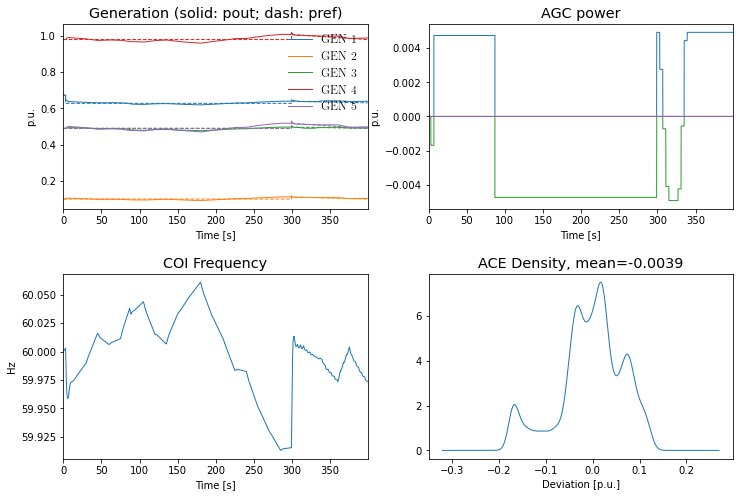

In [18]:
color=['tab:blue', 'tab:orange', 'tab:green',
       'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

yheader=['GEN 1', 'GEN 2', 'GEN 3', 'GEN 4', 'GEN 5']

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader, color=color,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   color=color,
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader, color=color,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 1],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 1].set(xlabel='Deviation [p.u.]', ylabel='')